# Character-level Convolutional Network
In this notebook we train and evaluate the performance of a convolutional neural network in the task of detecting misinformation in WhatsApp texts.

In [154]:
from __future__ import print_function
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import getTestMetrics
from imblearn.over_sampling import RandomOverSampler
%matplotlib inline
sns.set(style="whitegrid")

## Results

In [155]:
#save results in
base = '2018'
subset = 'viral'
path_dir = 'results/' + str(base) + '/' + subset + '/dl/'
file = 'dl_results.csv'
filepath = path_dir + file
filepath

'results/2018/viral/dl/dl_results.csv'

In [156]:
df_results = pd.read_csv(filepath)
cols = df_results.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_results = df_results[cols]
df_results = df_results.reset_index()
df_results = df_results.drop(columns = ['index'])
df_results = df_results.sort_values(by='f1 score',ascending=False)
df_results.style.background_gradient(cmap='Blues')

,vocab,layers,max_features,batch_size,embedding_dims,filters,kernel_size,hidden_dims,epochs,accuracy,precision,recall,f1 score,auc score
0,705,"<keras.layers.embeddings.Embedding, <keras.layers.core.Dropout, <keras.layers.convolutional.Conv1D, <keras.layers.pooling.GlobalMaxPooling1D, <keras.layers.core.Dense, <keras.layers.core.Dropout, <keras.layers.core.Activation, <keras.layers.core.Dense, <keras.layers.core.Activation,",2000,32,100,250,15,250,5,0.776727,0.770667,0.658314,0.710074,0.850674
1,705,"<keras.layers.embeddings.Embedding, <keras.layers.core.Dropout, <keras.layers.convolutional.Conv1D, <keras.layers.pooling.GlobalMaxPooling1D, <keras.layers.core.Dense, <keras.layers.core.Dropout, <keras.layers.core.Activation, <keras.layers.core.Dense, <keras.layers.core.Activation,",2000,32,100,250,15,250,5,0.776727,0.770667,0.658314,0.710074,0.850674


In [40]:
filepath = 'data/' + str(base) + '/fakeWhatsApp.BR_' + str(base) + '.csv'
df = pd.read_csv(filepath)

if subset == 'viral':
    df = df[df['viral']==1]
    
df.head(5)

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,viral,sharings,text,misinformation
1,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,58,9,1,2,O Bolsonaro tem que estar preparado pra respon...,0
15,3631133147603888180,10/08/18,14:31,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,99,18,1,2,"No dia 07 de Outubro, quando for votar, não es...",1
26,-4391661641377612003,11/08/18,19:28,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,114,17,1,6,Devido a aborrecimentos nas varias redes socia...,0
43,3631133147603888180,15/08/18,19:23,55,BRASIL,BRA,17,São Paulo,2018_1,0,1,330,47,1,7,EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM ...,0
103,-4391661641377612003,22/08/18,22:11,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,226,39,1,8,Como são as coisas.\nChefe do jacaré aparece n...,1


In [41]:
#removing duplicates
df = df.drop_duplicates(subset=['text'],keep = False)
#texts
texts = df[df['midia']==0]['text']
#target
y = df[df['midia']==0]['misinformation']

# Char vocabulary, encoding and decoding

In [142]:
txt_list = list(texts)
txt_str = " ".join(txt_list)
#word_list = msg_str.split()
char_list = list(txt_str)
vocab_set = set(char_list)
features = len(vocab_set)
print(features)

705


In [43]:
for v in list(vocab_set):
    print(v, end = ' ')

⬇ Ç 🕗 ⤵ ⣶ \ ❌ 🤺 à 🤪 🚈 🎋 👋 📲 📛 💟 💃 , 🤚 🔵 × 👏 ⢻ 🆘 🏁 ⠉ 😈 ̄ 💔 👴 🅱 🌿 U  ┫ 👜 ✳ ♀ 🔉 🛇 👌 😋 ⚠ 🌱 💡 😇 🤳 💝 l > 🧔 🌞 ⌚ 🤤 😸 💼 🙉 🔬 ç 😨 💩 ❕ 🚝 🆙 😴 🤢 🇼 ģ E 👊 🚛 ● ✊  🍦 	 S ⛽ 😠 ❤ 🔑 🔊 🍔 🤭 🤙 ⢲ ☑ ▶ ⏬ Ó 🙇 📘 á ❣ ⡋ = 🌟 🦑 😕 Ê 😛 ┛ 😯 🏡 🏦 🧚 ó  🏿 . 🤝 | 😮 😀 🍼 🖍 🚦 ê ⣴ 🏽 ] 🚨 💏 ☝ 💣 😪 💂 🍊 Â 🚍 - ⡛ ⚓ 💦 ↪ ┏ 💓 ' F 📄 e 🎀 ` ⛪ j u ‘ 🔛 Y 👳 ☕   $ 😍 🎧 😢 ☆ ⡻ 📜 🚜 🚫 🎥 😒 ■ 🏃 ⡄ [ Ñ 🍻 😞 ⠒ т 🤫 🏫 🇿 🇫 👙 q K ō 👱 👇 Ü 💅 ⠄ 💪 👺 % 📬 w ° 👪 😤 🚩 😌 © 🚐 – 🇱 🏼 🏍 x : / d 🧒 🥀 🤠 👍 📈 🇬 ñ 😓 💎 🦇 🏳 🤟 « 💖 🌸 t 🗞 B ⚜ 📣 👁 ⢠ m 🤐 õ h ⇩ ‭ 🕯 📆 🚙 📉 🚲 🇮 👶 🔍 📐 🙋 ⠿ s 📩 💄 😭 🍰 🌺 ⣭ 🧐 🌷 🔰 7 L ⠢ 🕥 À # ⡟ 👈 📌 ⚽ 😳 ! Ú 👎 1 💳 — 🗨 🐥 ⠟ 😜 🕓 ⡿ 🍺 🤜 🇦 i ⠋ 🕵 🍗 📱 🇺 ⣦ 🔗 🌎 🇷 ⚰ R 🔈 ⠧ 💸 🤛 Ė C 🌝 0 н 💨 📟 😲 🚴 💙 🛸 ɴ c 🍴 🤩 🐟 
 ♠ ┣ 🇳 É ⣉ J ☠ › G 😉 🐴 🤡 👸 k ü • P 🎾 🏹 😫 👟 Q 🙈 💯 ➖ 🚶 🖋 ” 😬 🐶 🌐 💶 🏻 🚕 ❗ 😏 🇰 🇧 🏆 g 🤔 ━ 📕 ã ⢀ 🚎 🇸 » 👉 🍨 → 🙌 + 👅 ┗ 🤦 φ 📚 4 ✏ 👦 ⡞ ; 🙆 ö ⠙ v 《 ➡ 💫 🚚 🏠 🔪 Ì 5 🎼 💘 💊 р 🇩 🐠 * o ♦ 🏴 😻 🤥 💴 ⡀ 🍞 🌾 ⣆ 📝 📢 😂 ~ ⭐ ⠈ 🤬 🚗 🎉 🍣 😰 🚔 🚑 👨 🖕 M 🐍 📏 ✝ Õ ✔ ⏳ 🌹 @ 🇹 🌵 🚌 с ⛓ 👥 Z 🔫 ⚔ ┃ 📖 

In [44]:
#dictionaries to encode char to indexes and indexes to char
char2Code = {}
code2Char = {0: ''}

i=1
for char in list(vocab_set):
    char2Code[char] = i
    code2Char[i] = char
    i+=1

In [45]:
#enconding and decoding fu
def vectorize(text, char2Code = char2Code):
    '''
    Enconding function: converts an string in code
    Input: string
    Output: coded string
    '''
    #text = text.lower()
    text_list = list(text)
    text_vector = []
    for token in text_list:
        if token in char2Code:
            code = char2Code[token]
            text_vector.append(code)
        else:
            text_vector.append(0)
    return(text_vector)

def unvectorize(vec, code2Char = code2Char):
    '''
    Decoding function: converts code in string
    Input: coded index list
    Output: string
    '''
    text = ''
    for i in vec:
        text += code2Char[i]
    return text
        
v = vectorize('This is a test!!! Gotcha? 🌝')
w = unvectorize(v)
print(v)
print(w)

[534, 231, 281, 245, 152, 281, 245, 152, 452, 152, 221, 141, 245, 221, 266, 266, 266, 152, 587, 661, 221, 309, 231, 452, 514, 152, 299]
This is a test!!! Gotcha? 🌝


In [46]:
X = np.array([(vectorize(x)) for x in texts])

# Distribuition of chars in documents

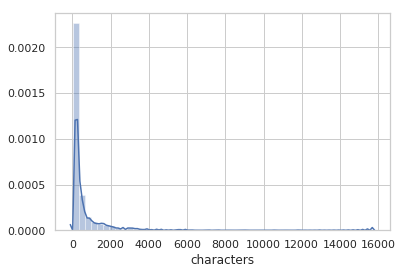

In [47]:
sns.distplot(df['characters'])

In [48]:
df['characters'].describe()

count     5284.000000
mean       484.764194
std        938.905845
min         23.000000
25%         95.750000
50%        177.000000
75%        410.250000
max      15683.000000
Name: characters, dtype: float64

In [49]:
#pad sequences that are bigger than maxlen
maxlen = 1000
X = sequence.pad_sequences(X, maxlen=maxlen)
print(X.shape)

(5284, 1000)


# Train-test split and oversampling

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

In [51]:
X_train.shape

(4227, 1000)

# Balancing

In [52]:
# random oversampling
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)
vocab_size = X_train.shape[1]    
X_train.shape

(4946, 1000)

# Build model

In [141]:
#hyperparameters:
max_features = 2000 #726 #196921 #corrigir
batch_size = 32
embedding_dims = 100
filters = 250
kernel_size = 15
hidden_dims = 250
epochs = 5

In [54]:
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions

#variar
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Build model...


In [55]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs)#,
          #validation_data=(X_test, y_test))

Epoch 1/5
4946/4946 [==============================] - 153s 31ms/step - loss: 0.6378 - acc: 0.6231
Epoch 2/5
4946/4946 [==============================] - 148s 30ms/step - loss: 0.5132 - acc: 0.7529
Epoch 3/5
4946/4946 [==============================] - 150s 30ms/step - loss: 0.3587 - acc: 0.8498
Epoch 4/5
4946/4946 [==============================] - 152s 31ms/step - loss: 0.1856 - acc: 0.9371
Epoch 5/5
4946/4946 [==============================] - 156s 32ms/step - loss: 0.0927 - acc: 0.9755


In [56]:
y_prob = model.predict(X_test)
y_pred = [0 if x < 0.5 else 1 for x in y_prob]

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       618
           1       0.77      0.66      0.71       439

    accuracy                           0.78      1057
   macro avg       0.78      0.76      0.76      1057
weighted avg       0.78      0.78      0.77      1057

AUC:  0.8506737878821387


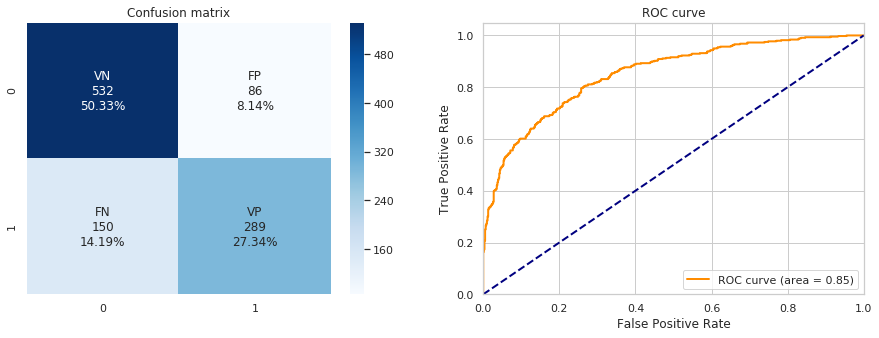

In [145]:
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

In [146]:
layers = ''
for layer in model.layers:
    layers += str(layer) + '/'
    
list_layers = layers.split('/')
list_layers = list_layers[:-1]
list_layers

layers = ''
for layer in list_layers:
    splitted = layer.split(' object at ')
    layers += splitted[0] + ', '
layers

'<keras.layers.embeddings.Embedding, <keras.layers.core.Dropout, <keras.layers.convolutional.Conv1D, <keras.layers.pooling.GlobalMaxPooling1D, <keras.layers.core.Dense, <keras.layers.core.Dropout, <keras.layers.core.Activation, <keras.layers.core.Dense, <keras.layers.core.Activation, '

In [147]:
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 100)         200000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1000, 100)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 986, 250)          375250    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 250)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_6 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_5 (Activation)    (None, 250)               0         
__________

In [148]:
layers_ = [layers]
max_features_ = [max_features]
batch_size_ = [batch_size]
embedding_dims_ = [embedding_dims]
filters_ = [filters]
kernel_size_ = [kernel_size]
hidden_dims_ = [hidden_dims]
epochs_ = [epochs]
acc_ = [acc]
precision_ = [precision]
recall_ = [recall]
f1_ = [f1]
roc_auc_ = [roc_auc]

In [149]:
df_metrics = pd.DataFrame({'layers':layers_,
                                 'max_features':max_features_,
                                 'batch_size':batch_size_,
                                 'embedding_dims':embedding_dims_,
                                 'filters':filters_,
                                 'kernel_size':kernel_size_, 
                                 'hidden_dims':hidden_dims_, 
                                 'epochs':epochs_,
                                 'accuracy':acc_,
                                 'precision': precision_,
                                 'recall': recall_,
                                 'f1 score': f1_,
                                 'auc score': roc_auc_})

df_metrics['vocab'] = [features]*len(df_metrics)
df_metrics

,layers,max_features,batch_size,embedding_dims,filters,kernel_size,hidden_dims,epochs,accuracy,precision,recall,f1 score,auc score,vocab
0,"<keras.layers.embeddings.Embedding, <keras.lay...",2000,32,100,250,15,250,5,0.776727,0.770667,0.658314,0.710074,0.850674,705


In [152]:
#df_metrics.to_csv(filepath, index = False)

In [158]:
df_results = pd.read_csv(filepath)
df_results = pd.concat([df_results, df_metrics])
df_results.drop_duplicates(inplace=True)
df_results.to_csv(filepath, index = False)
df_results

,layers,max_features,batch_size,embedding_dims,filters,kernel_size,hidden_dims,epochs,accuracy,precision,recall,f1 score,auc score,vocab
0,"<keras.layers.embeddings.Embedding, <keras.lay...",2000,32,100,250,15,250,5,0.776727,0.770667,0.658314,0.710074,0.850674,705
0,"<keras.layers.embeddings.Embedding, <keras.lay...",2000,32,100,250,15,250,5,0.776727,0.770667,0.658314,0.710074,0.850674,705


# Errors examples

In [58]:
full_texts_train, full_texts_test, yf_train, yf_test = train_test_split(texts, y, test_size=0.2, 
                                                                    stratify = y, random_state=42)

In [59]:
# 1-1 = 0 true positive
# 0-0 = 0 true negative
# 1-0 = 1 false negative
# 0-1 = -1 false positive
y_fails = y_test - y_pred
FN = [index for index, value in enumerate(y_fails) if value == 1]
FP = [index for index, value in enumerate(y_fails) if value == -1]

print('Total test data:', len(y_pred))
print('False negative: ',len(FN))
print('False positive: ',len(FP))

Total test data: 1057
False negative:  150
False positive:  86


In [60]:
full_texts_test = list(full_texts_test)
texts_FN = [full_texts_test[fn] for fn in FN]
texts_FP = [full_texts_test[fp] for fp in FP]

## False negative

In [61]:
for fn in texts_FN:
    print()
    print('***')
    print(fn)
    print('***')
    print()


***
Gente Apenas Minha Opinião então Vamos lá

No Dia 06 de Junho TSE Derruba o Voto Impresso de Autoria do deputado Federal Candidato a presidente Jair Bolsonaro

No Dia 06 de Setembro Jair Bolsonaro Sofre um Atentado que Seria pra MATAR

Um Dia Antes da Eleição Dia 06; Coincidência Se Juntar as Datas dar Certos 666 
Agora Bolsonaro corre novo Risco...

A que Interessa Isso ? Nova Ordem Mundial / Marconaria ? / iluminati ? / 
Peço que Compartilhem 
E Faca Chegar ao Bolsonaro

Breno Washington MG
Juntos somos fortes
***


***
Testemunho altamente confiável do meu amigo Dante Mantovani! Muito obrigado pelo texto tão esclarecedor e desmistificador, meu amigo: 

Após ter acompanhado Jair Bolsonaro pelo interior de SP por quatro cidades (Presidente Prudente, Araçatuba, Glicério e São José do Rio Preto), divido com vocês o que percebi até aqui:

1-)ao contrário do estereótipo que a mídia criou e que impõe goela abaixo ao seu público, a personalidade de Jair Bolsonaro é tremendamente afável

## False positive

In [62]:
for fp in texts_FP:
    print()
    print('***')
    print(fp)
    print('***')
    print()


***
TEXTO DA FUNDADORA DO DIRETÓRIO DO PT EM ARACAJU

Esquerda brasileira, chega de apontar culpados! Está na hora de assumir o ocorrido e partir prum mea culpa já!, antes que os Dórias e Bolssonaros assumam o poder! Quem elegeu Temer não foram os coxinhas. Parem de tergiversar. Temer foi eleito por vocês com dinheiro público desviado de hospitais, creches e escolas! O resto é retórica, ou ilação como vocês agora costumam chamar o que nós brasileiros conhecemos como mentira!

A arrogância da esquerda de acreditar que lida com tolos e que porta o Santo Graal está no pano de fundo de sua derrocada mundo afora.

Vamos fazer diferente e lavar a jato essa roupa suja antes que seja tarde! A máscara caiu!

Um homem que responsabiliza a companheira morta para não assumir seus atos é um covarde e não herói . Essa inversão de valores para mim é assustadora...

E não me venham falar da corrupção que existe desde a época de CABRAL que não somos trouxinhas...Nós militamos no PT e construímos esse 

# Separated embedding layer

In [63]:
# specifying the input shape
no_docs = len(X_train)
input=Input(shape=(no_docs,maxlen),dtype='float64')

'''
shape of input. 
each document has 12 element or words which is the value of our maxlen variable.
'''

word_input=Input(shape=(maxlen,),dtype='float64')  

# creating the embedding
word_embedding=Embedding(input_dim = max_features, output_dim = embedding_dims, input_length=maxlen)(word_input)

word_vec=Flatten()(word_embedding) # flatten
embed_model =Model([word_input],word_vec) # combining all into a Keras model

NameError: name 'Input' is not defined